# Part 1 Bagged Decision Tree

In this homework you are gonna learn 2 things how to use all processor on your machine(in python) and Bagged(Bootstrap Aggregating) Decision Tree.

Bagging(Bootstrap Aggregating) is a common way to prevent overfitting. The idea is to make a bunch of trees. Each with a handicapped data. To handicap the data, one could either use just the subset or just remove some features.

Then after you get a bunch of classifiers(trees) all we need to do is average the output.

Consider the following data write a Bagged Decision Tree out of it.

- For each tree use roughly half the sample (`np.random.choice` is your friend)
- Use minleaf of 20 or so.
- Train 100 trees.
- Make contour plot.

In [1]:
%matplotlib inline
import numpy as np
import math
from matplotlib import pyplot as plt
from collections import namedtuple
import pydot
from IPython.display import Image, display

(-5, 5)

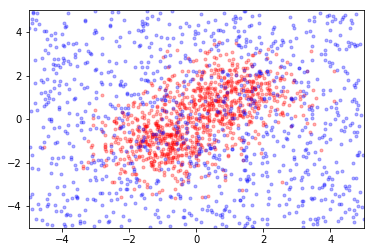

In [2]:
np.random.seed(1234)
nset = 500
xp11 = np.random.randn(nset,1)-1
xp21 = np.random.randn(nset,1)-1

xp12 = np.random.randn(nset,1)+1
xp22 = np.random.randn(nset,1)+1

xp1 = np.concatenate((xp11, xp12))
xp2 = np.concatenate((xp21, xp22))

pcls = np.zeros((nset*2))
pcls[:] = 1

xn1 = np.random.random((nset*2,1))*10-5
xn2 = np.random.random((nset*2,1))*10-5
ncls = np.zeros((1000))
ncls[:] = -1

x1s = np.concatenate([xp1, xn1])
x2s = np.concatenate([xp2, xn2])
cls = np.concatenate([pcls, ncls])
features = np.concatenate((x1s, x2s), axis=1)

cls>0
plt.plot(features[cls>0, 0], features[cls>0, 1], '.r', alpha=0.3)
plt.plot(features[cls<0, 0], features[cls<0, 1], '.b', alpha=0.3)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

In [3]:
class Node:
    def __init__(self):
        self.left = None
        self.right = None
        
    def is_leaf(self):
        return self.left is None and self.right is None
    
    def __str__(self):
        return 'hello'
test_root = Node()
test_root.left = Node()
test_root.right = Node()
print id(test_root), str(test_root)


4476448848 hello


In [4]:
def visualize_tree(node, depth_limit=10):
    graph = pydot.Dot(graph_type='digraph')
    visualize_tree_helper(node, graph, 0, depth_limit=depth_limit)
    display(Image(graph.create_png()))
    return graph
    
def visualize_tree_helper(node, graph, depth, depth_limit=10):
    
    if depth > depth_limit:
        print 'Traversing too deep'
        dotnode = pydot.Node('n%d'%id(node), label=str(node), shape="diamond", fillcolor="green", style="filled")
        graph.add_node(dotnode)
        return dotnode
    
    
    if not node.is_leaf():
        dotnode = pydot.Node('n%d'%id(node),label=str(node), shape="box")
    else:
        dotnode = pydot.Node('n%d'%id(node),label=str(node), shape="ellipse")
    graph.add_node(dotnode)
    
    if node.left is not None:
        dotleft = visualize_tree_helper(node.left, graph, depth+1, depth_limit)
        edge = pydot.Edge(dotnode, dotleft)
        graph.add_edge(edge)
    if node.right is not None:
        dotright = visualize_tree_helper(node.right, graph, depth+1, depth_limit)
        edge = pydot.Edge(dotnode, dotright)
        graph.add_edge(edge)
    return dotnode


In [5]:
# how a decision tree works
# how to grow a tree
class DecisionNode(Node):
    def __init__(self):
        Node.__init__(self)
        self.npos = 0
        self.nneg = 0
        self.vid = None
        self.cut = None
        
    def classify(self, data):
        if self.is_leaf():
            return float(self.npos)/(self.npos + self.nneg)
        
        if data[self.vid] > self.cut:
            return self.right.classify(data)
        else:
            return self.left.classify(data)
    
    def __str__(self):
        if self.is_leaf():
            return '(%d, %d)'%(self.npos, self.nneg)
        else:
            return 'ft[%d] < %.2f\n(%d,%d)'%(self.vid, self.cut, self.npos, self.nneg)

def make_decision_node(vid, cut, npos, nneg):
    node = DecisionNode()
    node.npos = npos
    node.nneg = nneg
    node.vid = vid
    node.cut = cut
    return node
    
def make_leaf_node(npos, nneg):
    node = DecisionNode()
    node.npos = npos
    node.nneg = nneg
    return node

In [8]:
def gini(cls):
    npos = sum(cls > 0)
    nneg = sum(cls < 0)
    if npos+nneg == 0:
        return 10.0
    p = float(npos)/(npos+nneg)
    return p*(1-p)

def theta(s):
    return 1./(1+math.exp(-s))

def nscore(ndata):
    return theta((ndata-25)/25)*.25

CutScore = namedtuple('CutScore', ['vid', 'cut', 'score', 'leftidx', 'rightidx'])

def find_bestcut(features, cls):
    nfeatures = features.shape[1]
    ntries = 10
    cut_scores = []
    for vid in range(nfeatures):
        minv, maxv = min(features[:, vid]), max(features[:, vid])
        cuts = np.linspace(minv, maxv, ntries+2)[1:-1]
        for cut in cuts:
            leftidx = features[:, vid] < cut
            nleft = sum(leftidx)
            rightidx = features[:, vid] >= cut
            nright = sum(rightidx)
            left_gini = gini(cls[leftidx])
            right_gini = gini(cls[rightidx])
            score = left_gini + right_gini + nscore(nleft) + nscore(nright)
            cut_scores.append(CutScore(vid, cut, score, leftidx, rightidx))
    
    #all scores for each cut is calculated select the one with lowest gini index
    bestcut = min(cut_scores, key=lambda x: x.score)
    return bestcut

find_bestcut(features, cls)

def make_tree(features, cls, minleaf=20):
    npos = sum(cls>0)
    nneg = sum(cls<0)
    nfeatures = features.shape[1]
    
    #base case
    if npos==0 or nneg==0 or npos+nneg < minleaf:
        return make_leaf_node(npos, nneg) 
    
    bestcut = find_bestcut(features, cls)
    decision_node = make_decision_node(bestcut.vid, bestcut.cut, npos, nneg)
    decision_node.left = make_tree(features[bestcut.leftidx], cls[bestcut.leftidx], minleaf)
    decision_node.right = make_tree(features[bestcut.rightidx], cls[bestcut.rightidx], minleaf)
    return decision_node

listOfListOfRandomInxdexes = []

#creates a list of lists, where each list contains ndatapoints indexes 
#so in this case I am creating 100 lists with 1000 random points from 0 - 2000
#without duplicates
def create_random_indexes(ntree,ndatapoints):
    for i in range(ntree):
        setOfRandomIndices = set()
        while (len(setOfRandomIndices) < ndatapoints):
            x = np.random.randint(0,2000)
            setOfRandomIndices.add(x)
        listOfListOfRandomInxdexes.append(list(setOfRandomIndices))
    return listOfListOfRandomInxdexes

#creates a forest using the random subset of indexes
#where the subset size == 1000

def create_forest(features,cls,lst_rand_idxs,ntree):
    forest = []
    for i in range(ntree):
        r_idxs = list_rand_idx[i]
        subset_features = features[r_idxs]
        subset_cls = cls[r_idxs]
        tree = make_tree(subset_features,subset_cls)
        forest.append(tree)
    return np.array(forest)



    

In [9]:
        
#list of list of random indices       
list_rand_idx = create_random_indexes(100,1000)
print 'hello'



hello


In [17]:
import time

In [18]:
#forest
start_time = time.time()
forest = create_forest(features,cls,list_rand_idx,100)
print("%s secs" % (time.time() - start_time))

188.573039055 secs


(-5, 5)

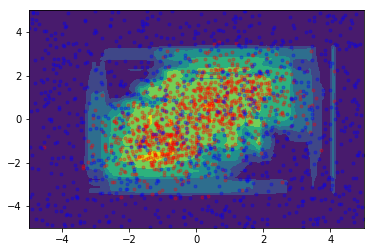

In [12]:
aa = np.linspace(-5, 5, 100)
bb = np.linspace(-5, 5, 100)
zs = np.zeros((100,100))

for ix1, a in enumerate(aa):
    for ix2, b in enumerate(bb):
        zs[ix1, ix2] = sum([tree.classify([a, b]) for tree in forest])/len(forest)
plt.contourf(aa, bb, zs.T)


plt.plot(features[cls>0, 0], features[cls>0, 1], '.r', alpha=0.3)
plt.plot(features[cls<0, 0], features[cls<0, 1], '.b', alpha=0.3)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

# Part 2 Parallelize your code

You can see that training 100 trees takes quite a while. In this problem your job is to modify your code a little bit so that it uses all processor on your machine.

**Save often. There is a chance it will crash your computer.**

https://docs.python.org/2/library/multiprocessing.html

In [13]:


from multiprocessing import Pool

def f(x):
    return x*x

p = Pool(5)
print(p.map(f, [1, 2, 3]))
p.close()

[1, 4, 9]


In [15]:

def create_tree(lst_rand_idxs):
    subset_features = features[lst_rand_idxs]
    subset_cls = cls[lst_rand_idxs]
    return make_tree(subset_features,subset_cls)

p = Pool(100)


In [19]:
start_time = time.time()
forest = p.map(create_tree, list_rand_idx)
print("%s secs" % (time.time() - start_time))

101.182791948 secs


(-5, 5)

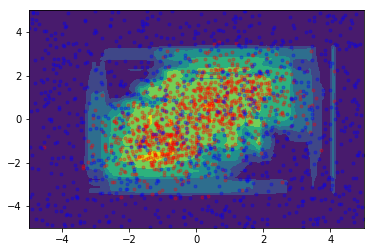

In [16]:
for ix1, a in enumerate(aa):
    for ix2, b in enumerate(bb):
        zs[ix1, ix2] = sum([tree.classify([a, b]) for tree in forest])/len(forest)
plt.contourf(aa, bb, zs.T)


plt.plot(features[cls>0, 0], features[cls>0, 1], '.r', alpha=0.3)
plt.plot(features[cls<0, 0], features[cls<0, 1], '.b', alpha=0.3)
plt.xlim(-5, 5)
plt.ylim(-5, 5)